# Hyperparameter Tuning

## 1. Data Reading


In [1]:
from catboost import CatBoostClassifier, Pool, cv, metrics, EShapCalcType, EFeaturesSelectionAlgorithm, CatBoost

from catboost.utils import get_roc_curve

import pandas as pd
import numpy as np
import pickle
import shap
import time as ts
import json
from time import time
import datetime
from pprint import pprint

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from catboost.utils import get_roc_curve

from imblearn.over_sampling import SMOTE, SMOTENC

from google.cloud import bigquery

import matplotlib.pyplot as plt
import sys
import ipywidgets as widgets

import joblib

import hyperopt

import optuna
# You can use Matplotlib instead of Plotly for visualization by simply replacing `optuna.visualization` with
# `optuna.visualization.matplotlib` in the following examples.
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
#from optuna.visualization import plot_rank
from optuna.visualization import plot_slice
#from optuna.visualization import plot_timeline


Jupyter-lab accesses a different optuna version than the terminal itsel(f3.5.0). ???

In [2]:
optuna.__version__

'3.0.3'

### 1.2 Data Loading
Read saved datasets that has already been preprocessed in Preprocessing notebook

In [3]:

X_train = pd.read_pickle('gs://jorquec_bucket/o2extras/X_train.pickle')
X_test = pd.read_pickle('gs://jorquec_bucket/o2extras/X_test.pickle')
y_train = pd.read_pickle('gs://jorquec_bucket/o2extras/y_train.pickle')
y_test = pd.read_pickle('gs://jorquec_bucket/o2extras/y_test.pickle')


In [4]:
print(len(X_train))
print(len(X_test)) 
print(len(y_train)) 
print(len(y_test)) 

28995
7249
28995
7249


In [5]:
# selecting rows based on condition
target1 = y_test.loc[y_test== 1]
target1

26243    1
24265    1
15697    1
17750    1
32926    1
        ..
34894    1
26343    1
29061    1
34682    1
1597     1
Name: target, Length: 397, dtype: int64

In [11]:
with open('/home/jupyter/o2extras/results/rfe-results-20240206-164032.json','r') as f:
    rfe_results = json.load(f)

In [12]:
selected_features=[rfe_results['12']['features']][0]

In [13]:
cat_features = [column for column, dtype in X_train.dtypes.items() if dtype==object]


In [14]:
bool_features = [column for column, dtype in X_train.dtypes.items() if dtype==bool]


In [15]:
X_train[cat_features]=X_train[cat_features].fillna('-999')
X_test[cat_features]=X_test[cat_features].fillna('-999')


In [16]:
feature_names = list(X_train.columns)
cat_features = [column for column, dtype in X_train.dtypes.items() if dtype==object]
train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

### 1.4 Hyperparameter Tuning - Exploring using the Optuna package

Bayesian optimization
Random and grid search pay no attention to past results when searhing the best hyperparametes. Bayesian optimization, in contrast to random or grid search, keeps track of past evaluation results which it uses to form a probabilistic model mapping hyperparameters to a probability of a score on the objective function. Libraries: optuna and hyperopt.

In [ ]:
# to run using .py script as notebook keeps disconeting, through terminal execute 
$   cd /home/jupyter/o2extras/
$  nohup python hyperparameter_tuning_o2extras.py

#You can check if its still running. Type : ps ax | grep hyperparameter_tuning_o2extras.py
#(in your jupyter terminal prompt)

In [17]:
# loading results from the json file
with open('/home/jupyter/o2extras/results/rfe-results-20240206-164032.json','r') as f:
    results_combined = json.load(f)

In [91]:
#Model not tuned
model_12 = CatBoostClassifier()
model_12.load_model('/home/jupyter/o2extras/results/model_12_features_not_tuned.dump');

In [18]:
selected_features=[rfe_results['12']['features']][0]

In [19]:
feature_names = [results_combined['12']['features']][0]
cat_features = [column for column, dtype in X_train[results_combined['12']['features']].dtypes.items() if dtype==object]

In [ ]:
#Hip.tuning

In [20]:

hyperameter_tuning_results = pd.read_pickle('/home/jupyter/o2extras/hyperparameter_tuning/hyperameter_tuning_results.pickle')


col:'values_0','values_1','values_2','values_3','values_4','values_5','values_6'      

objective:'maximize', 'maximize','minimize','maximize', 'maximize','maximize', 'maximize'

metric_name:mean_lift,mean_auc,mean_logloss,mean_precision,mean_recall,mean_accuracy,mean_f1


In [21]:

#pd.set_option('display.max_rows', None)
hyperameter_tuning_results

number  values_0  values_1  values_2  values_3  values_4  values_5  \
0        0  5.654346  0.859831  0.163160       1.0  0.008086  0.945408   
1        1  6.085581  0.875770  0.151199       1.0  0.141060  0.947231   
2        2  5.205794  0.845964  0.173682       1.0  0.001797  0.945162   
3        3  5.286713  0.850128  0.165837       1.0  0.008086  0.945211   
4        4  5.484182  0.856556  0.161366       1.0  0.095238  0.945704   
..     ...       ...       ...       ...       ...       ...       ...   
95      95  6.184149  0.878081  0.148374       1.0  0.147350  0.947428   
96      96  3.823510  0.790716  0.361040       1.0  0.006289  0.945162   
97      97  4.257423  0.804906  0.357526       1.0  0.000000  0.945162   
98      98  5.744589  0.864523  0.158489       1.0  0.042228  0.946048   
99      99  6.193140  0.880398  0.147359       1.0  0.135669  0.947773   

    values_6             datetime_start          datetime_complete  ...  \
0   0.015958 2024-02-11 16:17:09.986574 2024-02-11 16:41:48.628419  ...   
1   0.224799 2024-02-11 16:17:09.988003 2024-02-11 16:38:09.004365  ...   
2   0.003556 2024-02-11 16:17:09.989058 2024-02-11 16:39:54.246087  ...   
3   0.015075 2024-02-11 16:17:09.990100 2024-02-11 16:41:31.708355  ...   
4   0.158942 2024-02-11 16:17:09.991150 2024-02-11 16:35:45.548931  ...   
..       ...                        ...                        ...  ...   
95  0.231803 2024-02-11 16:17:10.860182 2024-02-11 16:41:06.061593  ...   
96  0.012059 2024-02-11 16:17:10.861124 2024-02-11 16:36:05.709846  ...   
97  0.000000 2024-02-11 16:17:10.862885 2024-02-11 16:38:49.929261  ...   
98  0.078478 2024-02-11 16:17:10.870348 2024-02-11 16:39:10.343635  ...   
99  0.219855 2024-02-11 16:17:10.873504 2024-02-11 16:40:53.147393  ...   

   params_boosting_type  params_bootstrap_type params_colsample_bylevel  \
0               Ordered               Bayesian                 0.711770   
1                 Plain                    MVS                 0.180697   
2                 Plain               Bayesian                 0.739743   
3                 Plain               Bayesian                 0.648623   
4                 Plain               Bayesian                 0.160085   
..                  ...                    ...                      ...   
95              Ordered                    MVS                 0.871565   
96                Plain               Bayesian                 0.504787   
97              Ordered                    MVS                 0.858707   
98              Ordered               Bayesian                 0.122716   
99              Ordered              Bernoulli                 0.973223   

   params_depth  params_l2_leaf_reg  params_learning_rate  \
0             9                   7              0.009309   
1             6                   4              0.065079   
2             7                   6              0.002613   
3             9                   3              0.005670   
4             7                   7              0.151543   
..          ...                 ...                   ...   
95            9                   1              0.017970   
96            6                   4              0.001095   
97            7                   8              0.001249   
98            8                   6              0.065531   
99            8                   7              0.015119   

    params_min_data_in_leaf  params_subsample  system_attrs_nsga2:generation  \
0                        48               NaN                              0   
1                        31               NaN                              0   
2                        32               NaN                              0   
3                        49               NaN                              0   
4                        84               NaN                              0   
..                      ...               ...                            ...   
95                  

In [22]:
jl= joblib.load('/home/jupyter/o2extras/hyperparameter_tuning/optuna_study_2024_02_09.pkl')

In [23]:
jl

In [24]:
print(jl.best_trials)

[FrozenTrial(number=14, values=[6.184149184133333, 0.8786692383061568, 0.14800365345070174, 1.0, 0.1707097933513028, 0.9482165038778811, 0.2626115004761231], datetime_start=datetime.datetime(2024, 2, 11, 16, 17, 10, 35961), datetime_complete=datetime.datetime(2024, 2, 11, 16, 40, 19, 608082), params={'learning_rate': 0.054605086407764666, 'depth': 10, 'colsample_bylevel': 0.6482708634817566, 'min_data_in_leaf': 46, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}, distributions={'learning_rate': FloatDistribution(high=0.4, log=True, low=0.001, step=None), 'depth': IntDistribution(high=10, log=False, low=6, step=1), 'colsample_bylevel': FloatDistribution(high=1.0, log=False, low=0.05, step=None), 'min_data_in_leaf': IntDistribution(high=100, log=False, low=1, step=1), 'l2_leaf_reg': IntDistribution(high=9, log=False, low=1, step=1), 'boosting_type': CategoricalDistribution(choices=('Ordered', 'Plain')), 'bootstrap_type': CategoricalDistribution(choices=('Bayesian',

In [25]:
study=jl

In [26]:
trials_df = study.trials_dataframe()

In [27]:
pd.set_option('display.max_rows', 10)
trials_df

number  values_0  values_1  values_2  values_3  values_4  values_5  \
0        0  5.654346  0.859831  0.163160       1.0  0.008086  0.945408   
1        1  6.085581  0.875770  0.151199       1.0  0.141060  0.947231   
2        2  5.205794  0.845964  0.173682       1.0  0.001797  0.945162   
3        3  5.286713  0.850128  0.165837       1.0  0.008086  0.945211   
4        4  5.484182  0.856556  0.161366       1.0  0.095238  0.945704   
..     ...       ...       ...       ...       ...       ...       ...   
95      95  6.184149  0.878081  0.148374       1.0  0.147350  0.947428   
96      96  3.823510  0.790716  0.361040       1.0  0.006289  0.945162   
97      97  4.257423  0.804906  0.357526       1.0  0.000000  0.945162   
98      98  5.744589  0.864523  0.158489       1.0  0.042228  0.946048   
99      99  6.193140  0.880398  0.147359       1.0  0.135669  0.947773   

    values_6             datetime_start          datetime_complete  ...  \
0   0.015958 2024-02-11 16:17:09.986574 2024-02-11 16:41:48.628419  ...   
1   0.224799 2024-02-11 16:17:09.988003 2024-02-11 16:38:09.004365  ...   
2   0.003556 2024-02-11 16:17:09.989058 2024-02-11 16:39:54.246087  ...   
3   0.015075 2024-02-11 16:17:09.990100 2024-02-11 16:41:31.708355  ...   
4   0.158942 2024-02-11 16:17:09.991150 2024-02-11 16:35:45.548931  ...   
..       ...                        ...                        ...  ...   
95  0.231803 2024-02-11 16:17:10.860182 2024-02-11 16:41:06.061593  ...   
96  0.012059 2024-02-11 16:17:10.861124 2024-02-11 16:36:05.709846  ...   
97  0.000000 2024-02-11 16:17:10.862885 2024-02-11 16:38:49.929261  ...   
98  0.078478 2024-02-11 16:17:10.870348 2024-02-11 16:39:10.343635  ...   
99  0.219855 2024-02-11 16:17:10.873504 2024-02-11 16:40:53.147393  ...   

   params_boosting_type  params_bootstrap_type params_colsample_bylevel  \
0               Ordered               Bayesian                 0.711770   
1                 Plain                    MVS                 0.180697   
2                 Plain               Bayesian                 0.739743   
3                 Plain               Bayesian                 0.648623   
4                 Plain               Bayesian                 0.160085   
..                  ...                    ...                      ...   
95              Ordered                    MVS                 0.871565   
96                Plain               Bayesian                 0.504787   
97              Ordered                    MVS                 0.858707   
98              Ordered               Bayesian                 0.122716   
99              Ordered              Bernoulli                 0.973223   

   params_depth  params_l2_leaf_reg  params_learning_rate  \
0             9                   7              0.009309   
1             6                   4              0.065079   
2             7                   6              0.002613   
3             9                   3              0.005670   
4             7                   7              0.151543   
..          ...                 ...                   ...   
95            9                   1              0.017970   
96            6                   4              0.001095   
97            7                   8              0.001249   
98            8                   6              0.065531   
99            8                   7              0.015119   

    params_min_data_in_leaf  params_subsample  system_attrs_nsga2:generation  \
0                        48               NaN                              0   
1                        31               NaN                              0   
2                        32               NaN                              0   
3                        49               NaN                              0   
4                        84               NaN                              0   
..                      ...               ...                            ...   
95                  

In [28]:
 # Sorting by column Lift
df_trialsorted = trials_df.sort_values(by=['values_0'], ascending=False)
df_trialsorted    

number  values_0  values_1  values_2  values_3  values_4  values_5  \
55      55  6.229104  0.878134  0.148293       1.0  0.159928  0.948069   
99      99  6.193140  0.880398  0.147359       1.0  0.135669  0.947773   
95      95  6.184149  0.878081  0.148374       1.0  0.147350  0.947428   
14      14  6.184149  0.878669  0.148004       1.0  0.170710  0.948217   
31      31  6.175158  0.877419  0.148314       1.0  0.153639  0.947527   
..     ...       ...       ...       ...       ...       ...       ...   
34      34  3.850483  0.792762  0.332699       1.0  0.000000  0.945162   
96      96  3.823510  0.790716  0.361040       1.0  0.006289  0.945162   
24      24  3.697969  0.771208  0.347831       1.0  0.000000  0.945162   
11      11  3.608392  0.775189  0.227579       1.0  0.000000  0.945162   
79      79  3.455877  0.772873  0.200875       1.0  0.000000  0.945162   

    values_6             datetime_start          datetime_complete  ...  \
55  0.249491 2024-02-11 16:17:10.490699 2024-02-11 16:40:00.775278  ...   
99  0.219855 2024-02-11 16:17:10.873504 2024-02-11 16:40:53.147393  ...   
95  0.231803 2024-02-11 16:17:10.860182 2024-02-11 16:41:06.061593  ...   
14  0.262612 2024-02-11 16:17:10.035961 2024-02-11 16:40:19.608082  ...   
31  0.240698 2024-02-11 16:17:10.252996 2024-02-11 16:40:27.666359  ...   
..       ...                        ...                        ...  ...   
34  0.000000 2024-02-11 16:17:10.284558 2024-02-11 16:38:30.241574  ...   
96  0.012059 2024-02-11 16:17:10.861124 2024-02-11 16:36:05.709846  ...   
24  0.000000 2024-02-11 16:17:10.197335 2024-02-11 16:26:28.113845  ...   
11  0.000000 2024-02-11 16:17:10.017616 2024-02-11 16:37:15.463356  ...   
79  0.000000 2024-02-11 16:17:10.708019 2024-02-11 16:30:00.968416  ...   

   params_boosting_type  params_bootstrap_type params_colsample_bylevel  \
55              Ordered                    MVS                 0.519268   
99              Ordered              Bernoulli                 0.973223   
95              Ordered                    MVS                 0.871565   
14              Ordered                    MVS                 0.648271   
31              Ordered              Bernoulli                 0.636348   
..                  ...                    ...                      ...   
34                Plain              Bernoulli                 0.174525   
96                Plain               Bayesian                 0.504787   
24              Ordered               Bayesian                 0.086663   
11              Ordered                    MVS                 0.059376   
79                Plain               Bayesian                 0.050171   

   params_depth  params_l2_leaf_reg  params_learning_rate  \
55            6                   2              0.031443   
99            8                   7              0.015119   
95            9                   1              0.017970   
14           10                   2              0.054605   
31            6                   3              0.031853   
..          ...                 ...                   ...   
34            9                   6              0.001087   
96            6                   4              0.001095   
24            9                   4              0.001696   
11            7                   6              0.002108   
79           10                   1              0.007453   

    params_min_data_in_leaf  params_subsample  system_attrs_nsga2:generation  \
55                       55               NaN                              0   
99                       92          0.678693                              0   
95                       13               NaN                              0   
14                       46               NaN                              0   
31                       10          0.621962                              0   
..                      ...               ...                            ...   
34                  

In [29]:
# Get parameters sorted by the importance values
importances = optuna.importance.get_param_importances(jl, target=lambda t: t.values[0])
params_sorted = list(importances.keys())

In [30]:
params_sorted

['bootstrap_type',
 'colsample_bylevel',
 'learning_rate',
 'l2_leaf_reg',
 'min_data_in_leaf',
 'boosting_type',
 'depth']

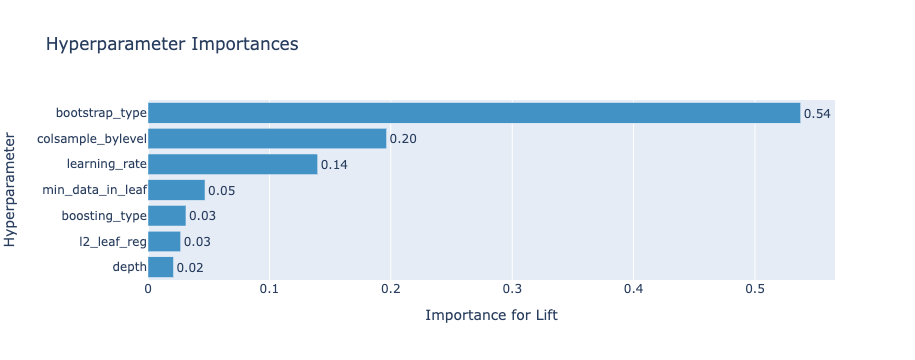

In [31]:
plot_param_importances(jl, target=lambda t: t.values[0], target_name='Lift')

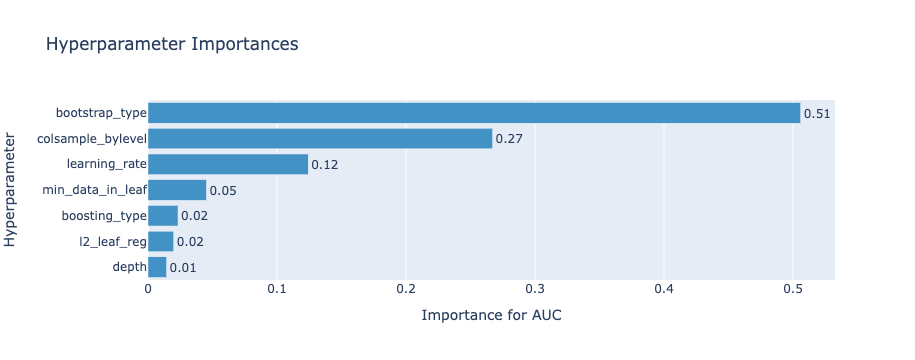

In [32]:
plot_param_importances(jl, target=lambda t: t.values[0], target_name='AUC')

In [ ]:
# Plot  # NOT AVAILABLE FOR  OPTUNA VERSION '3.0.3'
fig = optuna.visualization.plot_rank(jl, params=params_sorted[:5],target=lambda t: t.values[0], target_name='Lift')
fig.update_layout(
    autosize=False,
    width=1200,
    height=1000,
    margin=dict(l=50,r=50,b=100,t=100,pad=4),
)

fig.show()

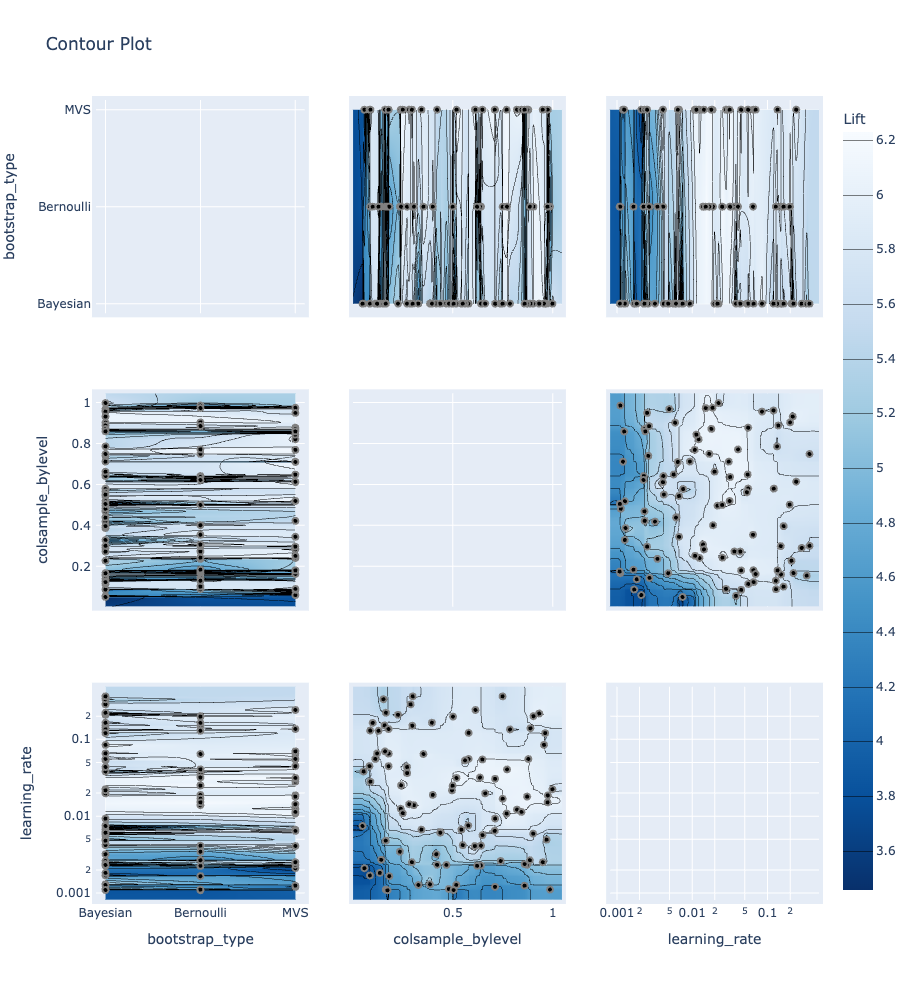

In [34]:
fig = plot_contour(jl, params=params_sorted[:3], target=lambda t: t.values[0], target_name="Lift")

fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(l=50,r=50,b=100,t=100,pad=4),
)

fig.show()

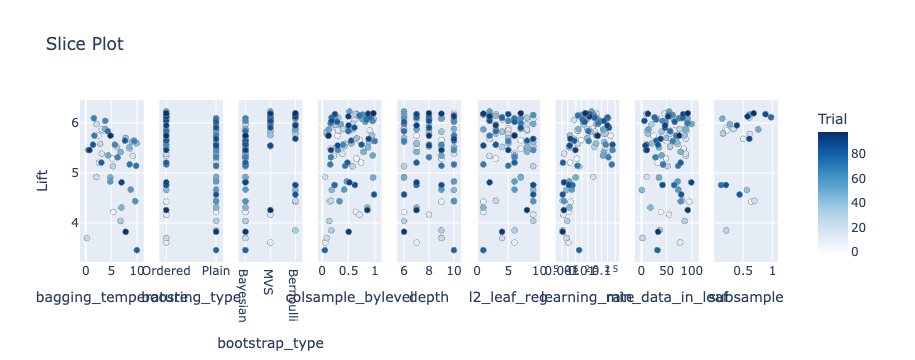

In [35]:
plot_slice(jl, target=lambda t: t.values[0], target_name="Lift")

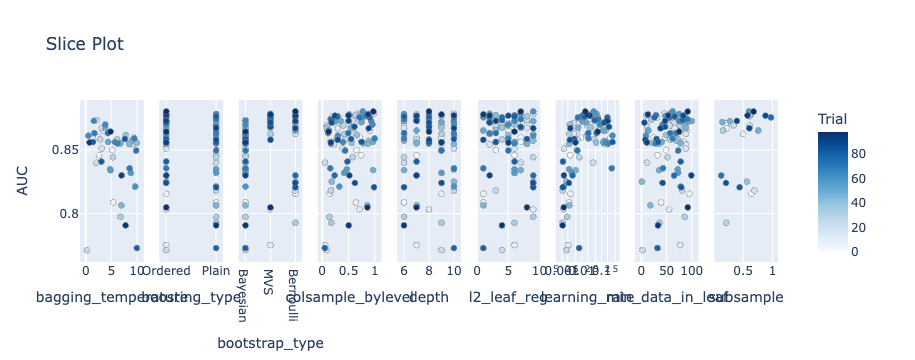

In [36]:
plot_slice(jl, target=lambda t: t.values[1], target_name="AUC")

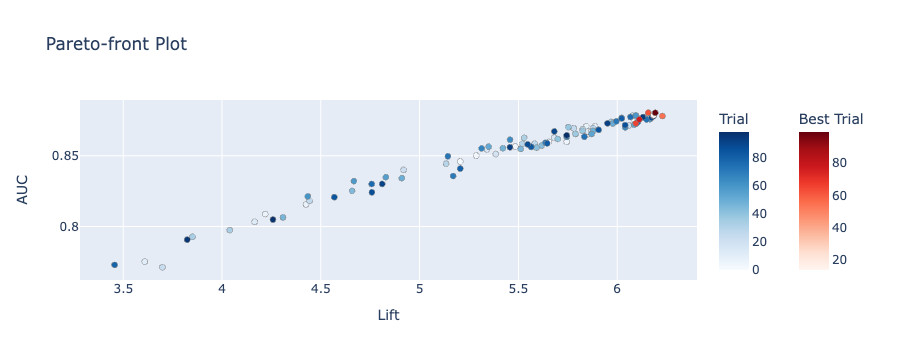

In [37]:
optuna.visualization.plot_pareto_front(jl, targets=lambda t: (t.values[0], t.values[1]), target_names=['Lift','AUC'])

In [38]:
print(f"Number of trials on the Pareto front: {len(jl.best_trials)}")

trial_with_highest_lift = max(jl.best_trials, key=lambda t: t.values[0])
print(f"Trial with highest lift: ")
print(f"\tnumber: {trial_with_highest_lift.number}")
print(f"\tparams: {trial_with_highest_lift.params}")
print(f"\tvalues: {trial_with_highest_lift.values}")

trial_with_highest_AUC = max(jl.best_trials, key=lambda t: t.values[1])
print(f"Trial with highest lift: ")
print(f"\tnumber: {trial_with_highest_AUC.number}")
print(f"\tparams: {trial_with_highest_AUC.params}")
print(f"\tvalues: {trial_with_highest_AUC.values}")

Number of trials on the Pareto front: 6
Trial with highest lift: 
	number: 55
	params: {'learning_rate': 0.03144286675102169, 'depth': 6, 'colsample_bylevel': 0.5192683736625437, 'min_data_in_leaf': 55, 'l2_leaf_reg': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}
	values: [6.2291042291, 0.878134156118608, 0.14829276011748974, 1.0, 0.15992812219227312, 0.9480686550879698, 0.24949074643354976]
Trial with highest lift: 
	number: 62
	params: {'learning_rate': 0.040598402863928115, 'depth': 8, 'colsample_bylevel': 0.7712404540674211, 'min_data_in_leaf': 62, 'l2_leaf_reg': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.59917762160357}
	values: [6.157176157166667, 0.8804401472681412, 0.14738767531398497, 1.0, 0.18688230008984727, 0.9487585020154611, 0.28376138677442236]


In [39]:
trial_with_highest_lift.params

{'learning_rate': 0.03144286675102169,
 'depth': 6,
 'colsample_bylevel': 0.5192683736625437,
 'min_data_in_leaf': 55,
 'l2_leaf_reg': 2,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'MVS'}

In [40]:
trial_with_highest_AUC.params

{'learning_rate': 0.040598402863928115,
 'depth': 8,
 'colsample_bylevel': 0.7712404540674211,
 'min_data_in_leaf': 62,
 'l2_leaf_reg': 9,
 'boosting_type': 'Ordered',
 'bootstrap_type': 'Bernoulli',
 'subsample': 0.59917762160357}

In [41]:
param = {

        "loss_function": 'Logloss',
        "eval_metric": 'AUC',
        "custom_loss" : [metrics.Accuracy(),metrics.Precision(),metrics.Recall(),metrics.F1(),metrics.AUC()],
        "random_seed": 22,
        "early_stopping_rounds":200,
        "logging_level":'Silent',
        "use_best_model":True,
        "thread_count": -1,
        
        "iterations": 3000,
        **trial_with_highest_lift.params
       
            }

In [42]:
param2 = {

        "loss_function": 'Logloss',
        "eval_metric": 'AUC',
        "custom_loss" : [metrics.Accuracy(),metrics.Precision(),metrics.Recall(),metrics.F1(),metrics.AUC()],
        "random_seed": 22,
        "early_stopping_rounds":200,
        "logging_level":'Silent',
        "use_best_model":True,
        "thread_count": -1,
        
        "iterations": 3000,
        **trial_with_highest_AUC.params
       
            }

In [43]:
# Using parameters with trial_with_highest_lift
feature_names = X_train.columns.to_list()
cat_features = [column for column, dtype in X_train.dtypes.items() if dtype==object]

train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

model = CatBoostClassifier(**param)

model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=0,
    early_stopping_rounds=200,
    plot=True
    )
print(model.get_all_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'nan_mode': 'Min', 'eval_metric': 'AUC', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 3000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'od_pval': 0, 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 2, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 0.5192683935165405, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'approx_on_full_history': False, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:Targe

In [44]:
model.save_model('/home/jupyter/o2extras/results/model_12features_tunedlift.dump')

In [45]:
#Model load LIFT
model = CatBoostClassifier()
model = model.load_model('/home/jupyter/o2extras/results/model_12features_tunedlift.dump')

In [46]:
# Same for AUC parameters2

In [47]:
# Using parameters with highest AUC
feature_names = X_train.columns.to_list()
cat_features = [column for column, dtype in X_train.dtypes.items() if dtype==object]

train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

model2 = CatBoostClassifier(**param2)

model2.fit(
    train_pool,
    eval_set=test_pool,
    verbose=0,
    early_stopping_rounds=200,
    plot=True
    )
print(model2.get_all_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

{'nan_mode': 'Min', 'eval_metric': 'AUC', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'], 'iterations': 3000, 'sampling_frequency': 'PerTree', 'fold_permutation_block': 0, 'leaf_estimation_method': 'Newton', 'od_pval': 0, 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Ordered', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'ctr_leaf_count_limit': 18446744073709551615, 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 9, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 0.7712404727935791, 'boost_from_average': False, 'max_ctr_complexity': 4, 'model_size_reg': 0.5, 'approx_on_full_history': False, 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:Targe

In [50]:
model2.save_model('/home/jupyter/o2extras/results/model_12features_tunedAUC.dump')

In [49]:
#Model to  load later
model2 = CatBoostClassifier()
model2 = model.load_model('/home/jupyter/o2extras/results/model_12features_tunedAUC.dump')

In [51]:
#### Apply models saved 

In [52]:
def create_decile_table(df,score_col,label_col,duplicates =False):
    
    'create deciles of the model output along with cumulative lift and gain'
    
    if duplicates:
        df_temp = df.groupby(pd.qcut(df[score_col], 10,duplicates='drop')).agg(no_of_customers=(score_col,'count'),
                                                                                  min_prob = (score_col,'min'),
                                                                                  max_prob = (score_col,'max'),
                                                                                  mean_prob = (score_col,'mean'),
                                                                                  o2extras=(label_col,'sum')).reset_index(drop = False).rename(columns =
                                                                                                                                          {score_col:'decile'}).sort_values('min_prob',
                                                                                                                                          ascending=False)
    else:
        df_temp = df.groupby(pd.qcut(df[score_col], 10,labels=range(10,0,-1))).agg(no_of_customers=(score_col,'count'),
                                                                                   min_prob = (score_col,'min'),
                                                                                   max_prob = (score_col,'max'),
                                                                                   mean_prob = (score_col,'mean'),
                                                                                   o2extras=(label_col,'sum')).reset_index(drop = False).rename(columns =
                                                                                                                                           {score_col:'decile'}).sort_values('min_prob',
                                                                                                                                           ascending=False)
    


    df_temp.insert(loc =2, column='cum_no_of_customers',value=df_temp['no_of_customers'].cumsum())
    df_temp.insert(loc =3, column='cum_per_no_of_customers',
               value=np.round(100*(df_temp['cum_no_of_customers']/df_temp['cum_no_of_customers'].max()),2))
    df_temp['o2extras_rate']=np.round(100*(df_temp['o2extras']/df_temp['no_of_customers']),2)
    df_temp['cum_o2extras']= df_temp['o2extras'].cumsum()
    df_temp['cum_per_o2extras']= np.round(100*(df_temp['cum_o2extras']/df_temp['cum_o2extras'].max()),2)
    df_temp['lift']=np.round(df_temp['cum_per_o2extras']/df_temp['cum_per_no_of_customers'],1)
    
    return df_temp

In [53]:
### Model was aved using trial_with_highest_lift
y_pred=model.predict_proba(X_test)[:,1]


In [54]:
evaluation_sumary = pd.DataFrame(y_test)
evaluation_sumary['pred_prob']=y_pred


In [55]:
evaluation_sumary

target  pred_prob
35449       0   0.027446
2127        0   0.011859
17281       0   0.044587
30700       0   0.008772
26243       1   0.611725
...       ...        ...
28709       0   0.006873
29543       0   0.004668
4686        0   0.151094
23          0   0.005243
21823       0   0.000594

[7249 rows x 2 columns]

In [56]:
evaluation_sumary_sorted = evaluation_sumary.sort_values(by=['target'], ascending=False)
evaluation_sumary_sorted

target  pred_prob
3763        1   0.058711
28592       1   0.615867
17584       1   0.062713
34913       1   0.123281
14361       1   0.350210
...       ...        ...
12753       0   0.035834
21384       0   0.000379
13998       0   0.056547
34811       0   0.014060
21823       0   0.000594

[7249 rows x 2 columns]

In [57]:
evaluation_sumary_sorted.sort_values(by='pred_prob', ascending=False, inplace=True)
evaluation_sumary_sorted

target  pred_prob
27273       0   0.869053
2167        1   0.827571
29153       1   0.824176
1341        1   0.805922
571         1   0.765218
...       ...        ...
21718       0   0.000030
21399       0   0.000029
21538       0   0.000027
20109       0   0.000026
21786       0   0.000025

[7249 rows x 2 columns]

In [58]:
df1 = evaluation_sumary_sorted.groupby('target', as_index=False)['pred_prob'].mean()
print (df1)

   target  pred_prob
0       0   0.039404
1       1   0.272692


In [59]:
# results for trial_with_highest_lift
o2extras_summary = create_decile_table(evaluation_sumary,'pred_prob','target',duplicates =False)
o2extras_summary


decile  no_of_customers  cum_no_of_customers  cum_per_no_of_customers  \
9      1              725                  725                    10.00   
8      2              725                 1450                    20.00   
7      3              725                 2175                    30.00   
6      4              725                 2900                    40.01   
5      5              724                 3624                    49.99   
4      6              725                 4349                    59.99   
3      7              725                 5074                    70.00   
2      8              725                 5799                    80.00   
1      9              725                 6524                    90.00   
0     10              725                 7249                   100.00   

   min_prob  max_prob  mean_prob  o2extras  o2extras_rate  cum_o2extras  \
9  0.110638  0.869053   0.325499       251          34.62           251   
8  0.055130  0.110602   0.075410        58           8.00           309   
7  0.035894  0.055117   0.044206        29           4.00           338   
6  0.024933  0.035888   0.030028        15           2.07           353   
5  0.016951  0.024930   0.020739        18           2.49           371   
4  0.010320  0.016950   0.013567        12           1.66           383   
3  0.005324  0.010319   0.007685        12           1.66           395   
2  0.001920  0.005322   0.003469         2           0.28           397   
1  0.000358  0.001919   0.000979         0           0.00           397   
0  0.000025  0.000356   0.000182         0           0.00           397   

   cum_per_o2extras  lift  
9             63.22   6.3  
8             77.83   3.9  
7             85.14   2.8  
6             88.92   2.2  
5             93.45   1.9  
4             96.47   1.6  
3             99.50   1.4  
2            100.00   1.2  
1            100.00   1.1  
0            100.00   1.0

In [60]:
roc_curve = get_roc_curve(model, test_pool)
(fpr , tpr , thresholds ) = roc_curve
roc_auc = auc(fpr , tpr )

print('AUC (Test set) = ', roc_auc)

AUC (Test set) =  0.8850011248990899


Best Threshold=0.055758, G-Mean=0.807


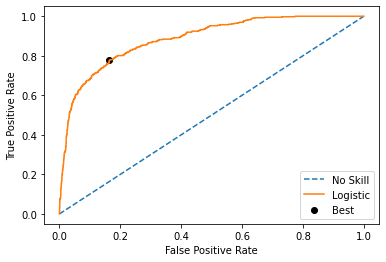

In [61]:
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)   # the indices of the maximum values.
best_th = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_th, gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# plt labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [62]:
# Tests for model2 which used AUC 

In [63]:
### Model was aved using trial_with_highest_AUC
y_pred=model2.predict_proba(X_test)[:,1]


In [64]:
evaluation_sumary2 = pd.DataFrame(y_test)
evaluation_sumary2['pred_prob']=y_pred


In [65]:
evaluation_sumary2

target  pred_prob
35449       0   0.027446
2127        0   0.011859
17281       0   0.044587
30700       0   0.008772
26243       1   0.611725
...       ...        ...
28709       0   0.006873
29543       0   0.004668
4686        0   0.151094
23          0   0.005243
21823       0   0.000594

[7249 rows x 2 columns]

In [66]:
evaluation_sumary_sorted2 = evaluation_sumary2.sort_values(by=['target'], ascending=False)
evaluation_sumary_sorted2

target  pred_prob
3763        1   0.058711
28592       1   0.615867
17584       1   0.062713
34913       1   0.123281
14361       1   0.350210
...       ...        ...
12753       0   0.035834
21384       0   0.000379
13998       0   0.056547
34811       0   0.014060
21823       0   0.000594

[7249 rows x 2 columns]

In [67]:
df2 = evaluation_sumary_sorted2.groupby('target', as_index=False)['pred_prob'].mean()
print (df2)

   target  pred_prob
0       0   0.039404
1       1   0.272692


In [68]:
# results for trial_with_highest_AUC
o2extras_summary2 = create_decile_table(evaluation_sumary2,'pred_prob','target',duplicates =False)
o2extras_summary2

decile  no_of_customers  cum_no_of_customers  cum_per_no_of_customers  \
9      1              725                  725                    10.00   
8      2              725                 1450                    20.00   
7      3              725                 2175                    30.00   
6      4              725                 2900                    40.01   
5      5              724                 3624                    49.99   
4      6              725                 4349                    59.99   
3      7              725                 5074                    70.00   
2      8              725                 5799                    80.00   
1      9              725                 6524                    90.00   
0     10              725                 7249                   100.00   

   min_prob  max_prob  mean_prob  o2extras  o2extras_rate  cum_o2extras  \
9  0.110638  0.869053   0.325499       251          34.62           251   
8  0.055130  0.110602   0.075410        58           8.00           309   
7  0.035894  0.055117   0.044206        29           4.00           338   
6  0.024933  0.035888   0.030028        15           2.07           353   
5  0.016951  0.024930   0.020739        18           2.49           371   
4  0.010320  0.016950   0.013567        12           1.66           383   
3  0.005324  0.010319   0.007685        12           1.66           395   
2  0.001920  0.005322   0.003469         2           0.28           397   
1  0.000358  0.001919   0.000979         0           0.00           397   
0  0.000025  0.000356   0.000182         0           0.00           397   

   cum_per_o2extras  lift  
9             63.22   6.3  
8             77.83   3.9  
7             85.14   2.8  
6             88.92   2.2  
5             93.45   1.9  
4             96.47   1.6  
3             99.50   1.4  
2            100.00   1.2  
1            100.00   1.1  
0            100.00   1.0

In [69]:
roc_curve = get_roc_curve(model2, test_pool)
(fpr , tpr , thresholds ) = roc_curve
roc_auc = auc(fpr , tpr )

print('AUC (Test set) = ', roc_auc)

AUC (Test set) =  0.8850011248990899


Best Threshold=0.055758, G-Mean=0.807


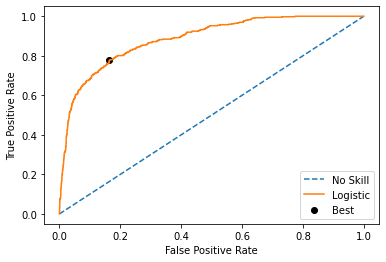

In [70]:
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_th = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (best_th, gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# plt labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [71]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=roc_curve)
(thresholds, fnr) = get_fnr_curve(curve=roc_curve)

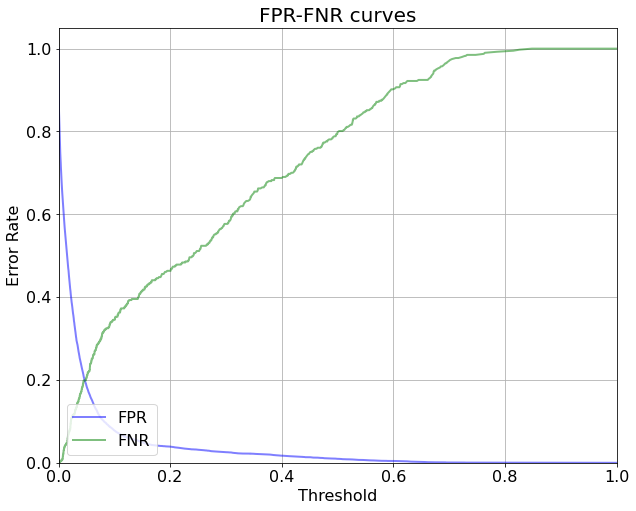

In [72]:
plt.figure(figsize=(10, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.savefig('/home/jupyter/o2extras/outputs/fpr_fnr_curves.png', bbox_inches='tight')
plt.show()


In [73]:
print(model.tree_count_)

1093


In [74]:
print(model2.tree_count_)

1093
